# 本地摄像头实时预测

同济子豪兄 2023-7-13 8-19

本地测试环境：Macbook Pro

## 进入mmsegmentation目录

In [1]:
import os
os.chdir('mmsegmentation')

## 摄像头预测-命令行

In [10]:
!python3 demo/video_demo.py \
         0 \
         Zihao-Configs/ZihaoDataset_FastSCNN_20230818.py \
         checkpoint/Zihao_FastSCNN.pth \
         --device cpu \
         --opacity 0.5 \
         --show

## 摄像头预测-OpenCV

### 导入工具包

In [2]:
import time
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
from mmseg.apis import init_model, inference_model

### 载入训练好的模型

In [3]:
# 模型 config 配置文件
config_file = 'Zihao-Configs/ZihaoDataset_FastSCNN_20230818.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'checkpoint/Zihao_FastSCNN.pth'

device = 'cpu'
# device = 'cuda:0'

In [11]:
model = init_model(config_file, checkpoint_file, device=device)

### 各类别的配色方案（BGR）

In [5]:
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [6]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

### 逐帧处理函数

In [7]:
opacity = 0.4 # 透明度，越大越接近原图

In [8]:
def process_frame(img_bgr):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    # 语义分割预测
    result = inference_model(model, img_bgr)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
    
    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')
    
    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    scaler = 1 # 文字大小
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_bgr = cv2.putText(pred_viz, FPS_string, (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)
    
    return img_bgr

### 调用摄像头拍摄一帧画面

In [14]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

time.sleep(1) # 等一秒，拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [15]:
frame.shape

(720, 1280, 3)

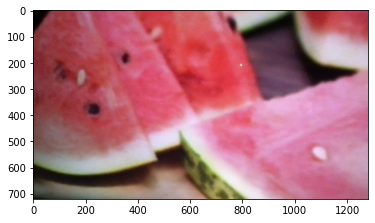

In [24]:
plt.imshow(frame[:,:,::-1])
plt.show()

In [17]:
frame = process_frame(frame)

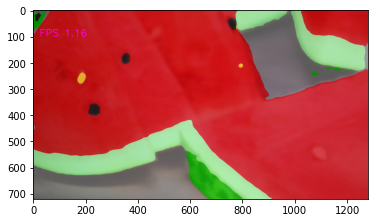

In [26]:
plt.imshow(frame[:,:,::-1])
plt.show()

### 摄像头实时画面逐帧处理

In [9]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 扩展阅读

Fast-SCNN论文：https://arxiv.org/abs/1902.04502

MMSegmentation模型库中的Fast-SCNN：https://github.com/open-mmlab/mmsegmentation/tree/main/configs/fastscnn

## 思考题

对比GPU和CPU，它们的速度、精度、预测结果有何不同？

对比原生pytorch的.pth模型文件预测，和后续模型部署预测，它们的速度、精度、预测结果有何不同？

对比不同语义分割模型，它们的速度、精度、预测结果有何不同？

摄像头实时画面处理时，处理一帧画面需要用时多久？时间都消耗在哪个部分？

如何进一步提升实时预测速度？